# **Senior Design Project - Brain Machine Interface**



### Krithik Parvataneni, Lisa Verma, Tsenbujin Tsendjav, Wencan Yang



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path_to_mat = '/content/drive/Shared drives/EEC174AY Group 8/Dataset/mat_data'
path_to_txt = '/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data'
path_to_model = '/content/drive/Shared drives/EEC174AY Group 8/models/'

## **All imports used**

In [3]:
import os
import keras
import random
import math
import torch
import numpy as np
import tensorflow as tf
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as data
import torchvision.datasets as datasets
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

## **Load the dataset**

## **Data preprocessing**
### **Data loader:** This will allow for less GPU usage. Works if all matlab files are in a separate directory.

In [4]:
class DataSet(data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.files = [file.path for file in os.scandir(self.root_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        mat_data = sio.loadmat(file_path)

        all_data = []
        all_data.append(mat_data)

        return all_data

In [5]:
# Change depending on the number of channels
class get_data():

    def __init__(self, mat_input, device):
        self.mat_input = mat_input
        self.device = device

    def get_movement(self, channels=None):
        movement_left = []
        movement_right = []
        movement_event = []
        sliced_left = []
        sliced_right = []
        index = []
        movement_event = self.mat_input['eeg']['movement_event'][0][0][0]
        # Can comment this for all channels or change it for different number of channels
        if channels == None:
          channels = [9, 11, 44, 48, 18, 45, 46, 55]
        # get raw dataset
        for i in channels:  # for fewer than 64 channels
        # for i in range(len(self.mat_input['eeg']['movement_left'][0][0])-4):    # uncomment for 64 (all EEG channels)
            movement_left.append(self.mat_input['eeg']['movement_left'][0][0][i])
            movement_right.append(self.mat_input['eeg']['movement_right'][0][0][i])
        #get onset (starting pt) of movement_event:
        for q in range(len(movement_event)):
            if movement_event[q] == 1:
                  index.append(q)
        #slice movement_left and right to only keep active region:
        for x in range(len(index)):
            temp_left = []
            temp_right = []
            for j in range(len(movement_left)):
                start_index = index[x]
                end_index = start_index + 1536 # three seconds for a period (512Hz)
                temp_left.append(movement_left[j][start_index:end_index])
                temp_right.append(movement_right[j][start_index:end_index])
            sliced_left.append(temp_left)
            sliced_right.append(temp_right)

        # convert to tensors and store on cuda for faster processing later on
        sliced_left_tensor = torch.tensor(np.array(sliced_left), device=self.device)
        sliced_right_tensor = torch.tensor(np.array(sliced_right), device=self.device)
        index_tensor = torch.tensor(np.array(index), device=self.device)

        return sliced_left_tensor, index_tensor, sliced_right_tensor

In [6]:
mat_data = DataSet(path_to_mat)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

move_left = []
move_right = []
move_idx = []
for subject in range(len(mat_data)):
  if subject < 20:    # uncomment and adjust the number of subjects for quick checks etc.
    left = []
    right = []
    index = []
    left, idx, right = get_data(mat_data[subject][0], device).get_movement()
    move_left.append(left)
    move_right.append(right)
    move_idx.append(idx)

In [7]:
def filter(input_tensor, window_size):
    total = []
    window = window_size
    new_length = 0
    for i in range(input_tensor.size(0)):
        one_trail = []
        for k in range(input_tensor.size(1)):
            one_channel = []
            for y in range(input_tensor.size(2)):
                if y >= window:
                    window_slice = input_tensor[i, k, y-window:y]
                    avg = torch.mean(window_slice)
                    one_channel.append(avg.item())  # Convert back to Python scalar
            one_trail.append(one_channel)
            new_length = len(one_channel)
        total.append(one_trail)

    # back to tensors
    total_tensor = torch.tensor(total, dtype=input_tensor.dtype, device=input_tensor.device)
    return total_tensor, new_length


move_right_filtered = []
move_left_filtered = []

# this will take the longest time as the number of channels increases
for subject in range(len(move_left)):
    left_filtered, new_timesteps = filter(move_left[subject], 32)
    move_left_filtered.append(left_filtered)

for subject in range(len(move_right)):
    right_filtered, new_timesteps = filter(move_right[subject], 32)
    move_right_filtered.append(right_filtered)

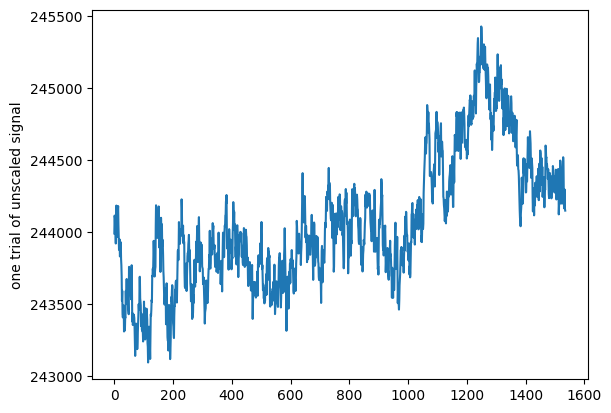

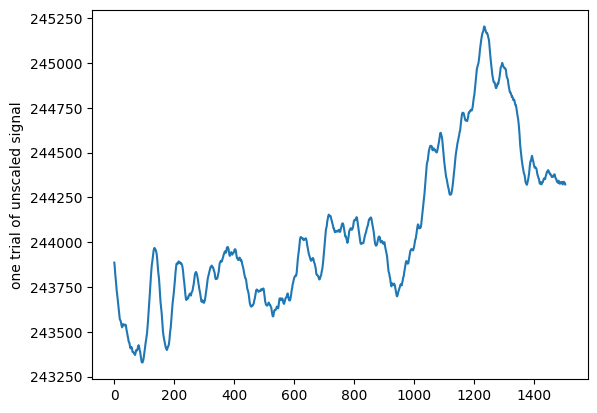

In [8]:
move_left_cpu = move_left[19][1][3].cpu() #[subject][trial][channel]
# Convert tensor to numpy array
left_numpy = move_left_cpu.detach().numpy()

plt.plot(left_numpy)
plt.ylabel('one trial of unscaled signal')
plt.show()

filtered_left_cpu = move_left_filtered[19][1][3].cpu() #[subject][trial][channel]
# Convert tensor to numpy array
left_numpy = filtered_left_cpu.detach().numpy()

plt.plot(left_numpy)
plt.ylabel('one trial of unscaled signal')
plt.show()

In [9]:
def reshape(input_tensor):
    output_tensor = []
    for i in range(input_tensor.size(0)):
        each_trail = []
        before_trans = input_tensor[i].cpu().detach().numpy()
        transposed_tensor = torch.tensor(before_trans.transpose(), dtype=input_tensor.dtype, device=input_tensor.device)
        output_tensor.append(transposed_tensor)
    return output_tensor


def normalize(input_data):
    output_data = []
    for i in range(len(input_data)):
        scaler = StandardScaler()
        scaler.fit(input_data[i])
        scaled_X = scaler.transform(input_data[i])
        output_data.append(scaled_X)
    return output_data


# this is for performance visualization
from keras.callbacks import Callback
class LossAccHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accs = []
        self.val_losses = []
        self.val_accs = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accs.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_accs.append(logs.get('val_accuracy'))

### Reshape the input data:

In [10]:
move_right_reshaped = []
move_left_reshaped = []

for subject in range(len(move_left_filtered)):
    left_reshaped = reshape(move_left_filtered[subject])
    move_left_reshaped.append(left_reshaped)

for subject in range(len(move_right_filtered)):
    right_reshaped = reshape(move_right_filtered[subject])
    move_right_reshaped.append(right_reshaped)

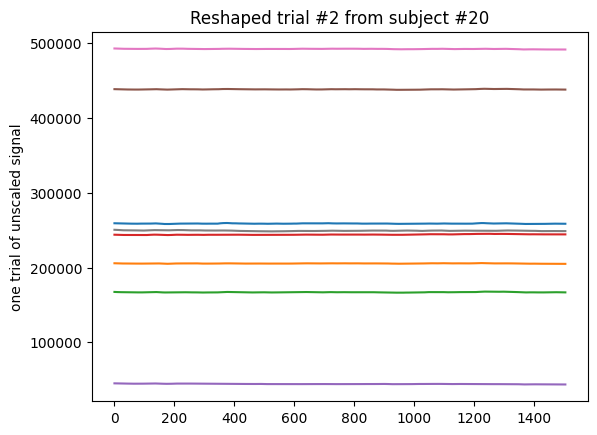

In [11]:
move_left_cpu = move_left_reshaped[19][1].cpu() # [subject][trial]
# Convert tensor to numpy array
left_numpy = move_left_cpu.detach().numpy()

plt.plot(left_numpy)
plt.title('Reshaped trial #2 from subject #20')
plt.ylabel('one trial of unscaled signal')
plt.show()

### Normalize the input data (for visualization only, we'll use a non-tensor normalize() function for the input data later to train):

In [12]:
def normalize_tensor(input_data):
    output_tensor = []
    device = input_data[0].device
    for i in range(len(input_data)):
        scaler = StandardScaler()
        numpy_data = input_data[i].cpu().detach().numpy()
        scaler.fit(numpy_data)
        scaled_data = torch.tensor(scaler.transform(numpy_data), device=device)
        output_tensor.append(scaled_data)
    return output_tensor

In [13]:
move_right_normalized = []
move_left_normalized = []

for subject in range(len(move_left_reshaped)):
    left_normalized = normalize_tensor(move_left_reshaped[subject])
    move_left_normalized.append(left_normalized)

for subject in range(len(move_right_reshaped)):
    right_normalized = normalize_tensor(move_right_reshaped[subject])
    move_right_normalized.append(right_normalized)

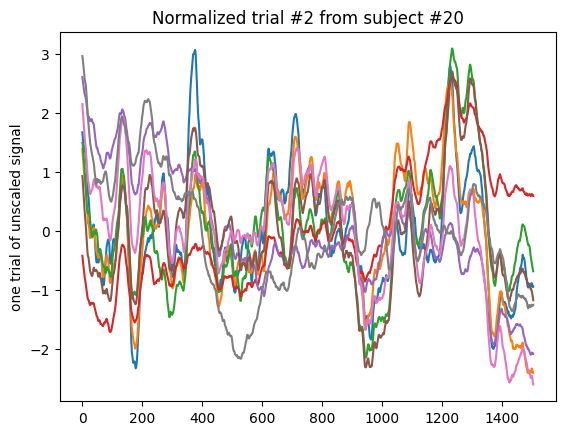

In [14]:
move_left_cpu = move_left_normalized[19][1].cpu() # [subject][trial][datapoint]
# Convert tensor to numpy array
left_numpy = move_left_cpu.detach().numpy()

plt.plot(left_numpy)
plt.title("Normalized trial #2 from subject #20")
plt.ylabel('one trial of unscaled signal')
plt.show()

In [15]:
label = []
X = []
for i in range(len(move_left_reshaped)):
    label.append([0]) # left - class 0
    X.append(move_left_reshaped[i])
for y in range(len(move_right_reshaped)):
    label.append([1]) # right - class 1
    X.append(move_right_reshaped[y])

# shuffle arrays for randomness:
temp = list(zip(X, label))
random.seed(7)
random.shuffle(temp)
X, label = zip(*temp)
label = np.array(label)
X = np.array([item[0].cpu().detach().numpy() for item in X])
element_num = len(X)
train_index = element_num * 0.8 # train and test split 80:20
train_index = math.floor(train_index)
scaled_X = normalize(X) #normalize input data
scaled_X = np.array(scaled_X)
train_X = scaled_X[:train_index]
train_label = label[:train_index]
test_X = scaled_X[train_index:]
test_label = label[train_index:]

val_data = (test_X, test_label)

In [16]:
time_steps = new_timesteps
n_features = 8

device = '/gpu:0'
with tf.device(device):
    model = Sequential()
    model.add(Conv1D(filters=100,
                    kernel_size=75,
                    strides=1,
                    activation='relu',
                    padding='same'))
    model.add(Dropout(0.6))
    model.add(Conv1D(filters=250,
                    kernel_size=75,
                    strides=1,
                    activation='relu',
                    padding='same'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(4))
    model.add(Conv1D(filters=150,
                    kernel_size=75,
                    strides=1,
                    activation='relu',
                    padding='same'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(4))
    model.add(Conv1D(75, 75, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    sgd = keras.optimizers.SGD(0.002, 0.9, False)
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    history = LossAccHistory()
    rnn = model.fit(train_X, train_label, batch_size=4, epochs=50, validation_data=val_data, verbose=0, callbacks=[history])

history_dict = {
    "Epoch": range(1, len(history.losses) + 1),
    "Train Loss": history.losses,
    "Train Accuracy": history.accs,
    "Validation Loss": history.val_losses,
    "Validation Accuracy": history.val_accs
}

history_df = pd.DataFrame(history_dict)
display(history_df)

,Epoch,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy
0,1,1.965983,0.50000,0.691929,0.500
1,2,0.878225,0.43750,0.692179,0.500
2,3,0.800579,0.65625,0.694024,0.500
3,4,0.712978,0.53125,0.693945,0.500
4,5,0.707713,0.53125,0.690996,0.750
5,6,0.619100,0.75000,0.685031,0.500
6,7,0.586980,0.68750,0.690597,0.625
7,8,0.439521,0.84375,0.635419,0.500
8,9,0.593268,0.71875,0.811309,0.500
9,10,0.781830,0.68750,0.693033,0.500


### Report training averages:

In [17]:
train_loss_avg = np.mean(history.losses)
train_loss_std = np.std(history.losses)
train_accuracy_avg = np.mean(history.accs)
train_accuracy_std = np.std(history.accs)
val_loss_avg = np.mean(history.val_losses)
val_loss_std = np.std(history.val_losses)
val_accuracy_avg = np.mean(history.val_accs)
val_accuracy_std = np.std(history.val_accs)

print("Average Train Loss: {:.2f}% +/- {:.2f}%".format(train_loss_avg * 100, train_loss_std * 100))
print("Average Train Accuracy: {:.2f}% +/- {:.2f}%".format(train_accuracy_avg * 100, train_accuracy_std * 100))
print("Average Validation Loss: {:.2f}% +/- {:.2f}%".format(val_loss_avg * 100, val_loss_std * 100))
print("Average Validation Accuracy: {:.2f}% +/- {:.2f}%".format(val_accuracy_avg * 100, val_accuracy_std * 100))


Average Train Loss: 846.84% +/- 4511.56%
Average Train Accuracy: 70.50% +/- 13.33%
Average Validation Loss: 103.45% +/- 68.20%
Average Validation Accuracy: 46.50% +/- 10.01%


### Evaluate the model performance:

In [18]:
evaluation = model.evaluate(test_X, test_label)

test_loss_avg = evaluation[0]
test_accuracy_avg = evaluation[1]

print("Test Loss: {:.2f}%".format(test_loss_avg * 100))
print("Test Accuracy: {:.2f}%".format(test_accuracy_avg * 100))


1/1 [==============================] - 1s 771ms/step - loss: 0.6939 - accuracy: 0.5000
Test Loss: 69.39%
Test Accuracy: 50.00%


### Visualize the learning curves:

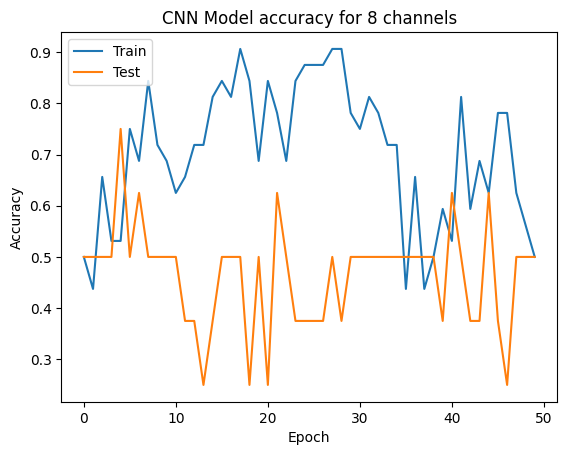

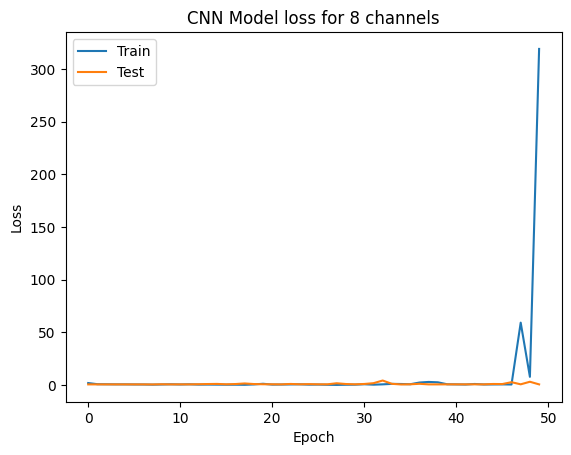

In [19]:
#Visualize Result
# Plot training & validation accuracy values
plt.plot(rnn.history['accuracy'])
plt.plot(rnn.history['val_accuracy'])
plt.title('CNN Model accuracy for 8 channels')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(rnn.history['loss'])
plt.plot(rnn.history['val_loss'])
plt.title('CNN Model loss for 8 channels')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Model visualization:

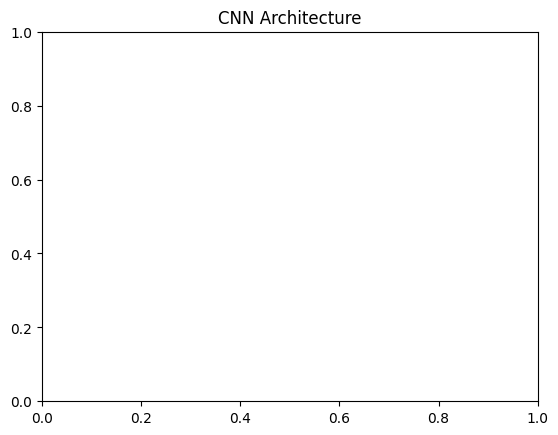

In [20]:
from keras.utils import plot_model
plot_model(model)

plt.title("CNN Architecture")
plt.show()

### Save the best performing model:

In [21]:
model.save(os.path.join(path_to_model, 'cnn.pth'))

### K-Fold cross validation on CNN:

In [22]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []

time_steps = new_timesteps
n_features = 8

model = Sequential()
model.add(Conv1D(filters=150,
                kernel_size=75,
                strides=1,
                activation='relu',
                padding='same'))
model.add(Dropout(0.6))
model.add(Conv1D(filters=250,
                kernel_size=75,
                strides=1,
                activation='relu',
                padding='same'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(4))
model.add(Conv1D(75, 75, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
sgd = keras.optimizers.SGD(0.002, 0.9, False)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

device = '/gpu:0'
for train, test in kfold.split(X, label):
    val_data = (X[test], label[test])
    with tf.device(device):
      rnn = model.fit(X[train], label[train], batch_size=4, epochs=50, verbose=0)
      scores = model.evaluate(X[test], label[test], verbose=0)
      print('%s: %.2f%%' % (model.metrics_names[1], scores[1]*100))
      cvscores.append(scores[1] * 100)
print('%.2f%% (+/- %.2f%%)' % (np.mean(cvscores), np.std(cvscores)))

accuracy: 50.00%
accuracy: 50.00%
accuracy: 50.00%
accuracy: 50.00%
accuracy: 50.00%
50.00% (+/- 0.00%)


### **LSTM**

In [23]:
device = '/gpu:0'
with tf.device(device):
    time_steps = new_timesteps
    n_features = 8
    # write validation data into a tuple:
    val_data = (test_X, test_label)
    model = Sequential()
    model.add(Conv1D(filters=128,
                    kernel_size=64,
                    strides=1,
                    activation='relu',
                    padding='same',
                    input_shape=(time_steps, n_features)))
    model.add(LSTM(75, return_sequences=True, input_shape=(time_steps, n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(75, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(1, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    sgd = keras.optimizers.SGD(0.002, 0.9, False)
    # model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    history = LossAccHistory()
    rnn = model.fit(train_X, train_label, batch_size=4, epochs=50, validation_data=val_data, verbose=0, callbacks=[history])

history_dict = {
    "Epoch": range(1, len(history.losses) + 1),
    "Train Loss": history.losses,
    "Train Accuracy": history.accs,
    "Validation Loss": history.val_losses,
    "Validation Accuracy": history.val_accs
}

history_df = pd.DataFrame(history_dict)
display(history_df)

,Epoch,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy
0,1,0.690854,0.62500,0.693822,0.500
1,2,0.691987,0.50000,0.689506,0.500
2,3,0.687012,0.65625,0.683858,0.750
3,4,0.684304,0.56250,0.680230,0.750
4,5,0.689685,0.50000,0.687294,0.625
5,6,0.684004,0.71875,0.691226,0.375
6,7,0.679140,0.75000,0.687940,0.625
7,8,0.676904,0.75000,0.680641,0.750
8,9,0.675273,0.71875,0.687254,0.500
9,10,0.673919,0.75000,0.694543,0.375


### Report training averages:

In [24]:
train_loss_avg = np.mean(history.losses)
train_loss_std = np.std(history.losses)
train_accuracy_avg = np.mean(history.accs)
train_accuracy_std = np.std(history.accs)
val_loss_avg = np.mean(history.val_losses)
val_loss_std = np.std(history.val_losses)
val_accuracy_avg = np.mean(history.val_accs)
val_accuracy_std = np.std(history.val_accs)

print("Average Train Loss: {:.2f}% +/- {:.2f}%".format(train_loss_avg * 100, train_loss_std * 100))
print("Average Train Accuracy: {:.2f}% +/- {:.2f}%".format(train_accuracy_avg * 100, train_accuracy_std * 100))
print("Average Validation Loss: {:.2f}% +/- {:.2f}%".format(val_loss_avg * 100, val_loss_std * 100))
print("Average Validation Accuracy: {:.2f}% +/- {:.2f}%".format(val_accuracy_avg * 100, val_accuracy_std * 100))


Average Train Loss: 62.10% +/- 4.81%
Average Train Accuracy: 72.44% +/- 9.03%
Average Validation Loss: 68.64% +/- 8.20%
Average Validation Accuracy: 53.50% +/- 18.03%


### Evaluate the model performance:

In [25]:
evaluation = model.evaluate(test_X, test_label)

test_loss_avg = evaluation[0]
test_accuracy_avg = evaluation[1]

print("Test Loss: {:.2f}%".format(test_loss_avg * 100))
print("Test Accuracy: {:.2f}%".format(test_accuracy_avg * 100))

1/1 [==============================] - 1s 1s/step - loss: 0.9667 - accuracy: 0.1250
Test Loss: 96.67%
Test Accuracy: 12.50%


### Visualize the training result:

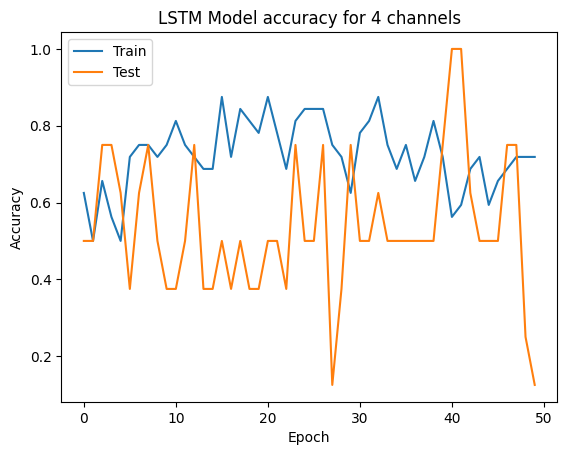

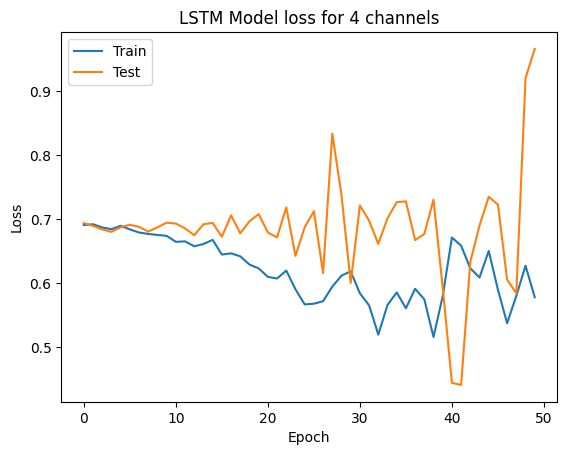

In [26]:
#Visualize Result
# Plot training & validation accuracy values
plt.plot(rnn.history['accuracy'])
plt.plot(rnn.history['val_accuracy'])
plt.title('LSTM Model accuracy for 4 channels')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(rnn.history['loss'])
plt.plot(rnn.history['val_loss'])
plt.title('LSTM Model loss for 4 channels')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

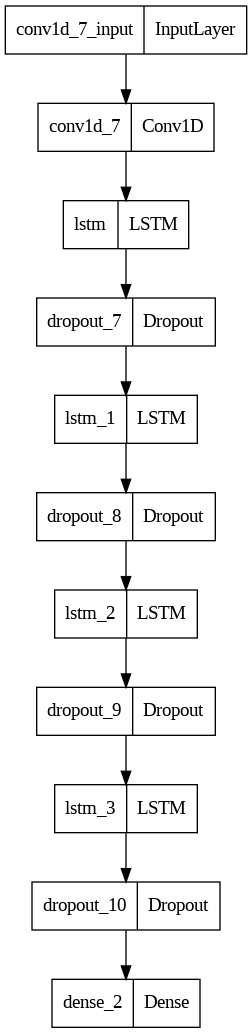

In [27]:
from keras.utils import plot_model
plot_model(model)

### Save the best performing model:

In [28]:
model.save(os.path.join(path_to_model, 'test3-13.pth'))

### **Additional visual aids**

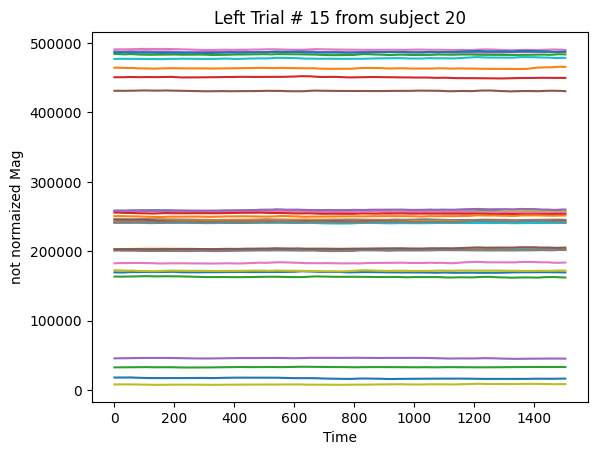

In [29]:
trail01 = move_left_reshaped[19][0].cpu() # [subject][trial]
trail05 = move_left_reshaped[19][4].cpu()
trail10 = move_left_reshaped[19][9].cpu()
trail15 = move_left_reshaped[19][14].cpu()
plt.plot(trail01)
plt.title('Left Trial # 1 from subject 20')
plt.xlabel('Time')
plt.ylabel('non normaized Mag')
# plt.show()
plt.plot(trail05)
plt.title('Left Trial # 5 from subject 20')
plt.xlabel('Time')
plt.ylabel('not normaized Mag')
# plt.show()
plt.plot(trail10)
plt.title('Left Trial # 10 from subject 20')
plt.xlabel('Time')
plt.ylabel('not normaized Mag')
# plt.show()
plt.plot(trail15)
plt.title('Left Trial # 15 from subject 20')
plt.xlabel('Time')
plt.ylabel('not normaized Mag')
plt.show()

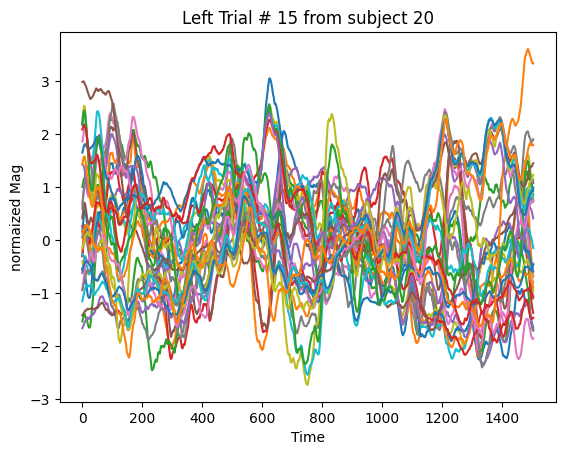

In [30]:
ntrail01 = move_left_normalized[19][0].cpu() # [subject][trial]
ntrail05 = move_left_normalized[19][4].cpu()
ntrail10 = move_left_normalized[19][9].cpu()
ntrail15 = move_left_normalized[19][14].cpu()
plt.plot(ntrail01)
plt.title('Left Trial # 1 from subject 20')
plt.xlabel('Time')
plt.ylabel('normaized Mag')
# plt.show()
plt.plot(ntrail05)
plt.title('Left Trial # 5 from subject 20')
plt.xlabel('Time')
plt.ylabel('normaized Mag')
# plt.show()
plt.plot(ntrail10)
plt.title('Left Trial # 10 from subject 20')
plt.xlabel('Time')
plt.ylabel('normaized Mag')
# plt.show()
plt.plot(ntrail15)
plt.title('Left Trial # 15 from subject 20')
plt.xlabel('Time')
plt.ylabel('normaized Mag')
plt.show()

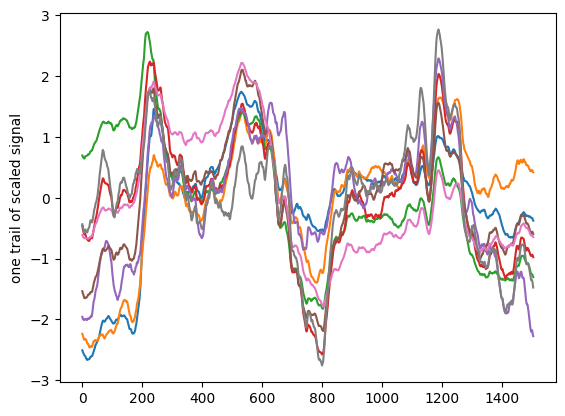

In [31]:
plt.plot(scaled_X[9])
plt.ylabel('one trail of scaled signal')
plt.show()

### **OpenBCI data processing**

In [32]:
import os
from torch.utils import data
from scipy.signal import resample

class DataSet(data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.files = [file.path for file in os.scandir(self.root_dir) if file.name.endswith('.txt')]
        self.transform = transform

        # have to make sure if this is the case in the data directory
        self.left_data = self.files[:20]
        self.move_data = self.files[20:]
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if idx < len(self.left_data):
            file_path = self.left_data[idx]
            label = 0  # left - class 0
        else:
            file_path = self.move_data[idx - len(self.left_data)]
            label = 1  # right - class 1
        print(file_path)

        # Reading data from file
        data = np.transpose(pd.read_csv(file_path, skiprows=5).iloc[1700:3500, 1:5].to_numpy())
        data = resample(data, num=int(len(data[0]) * (512 / 800)), axis=1)

        # Applying any transformations if needed
        if self.transform:
            data = self.transform(data)

        return data, label


In [33]:
data = DataSet(path_to_txt)

for i in range(len(data)):
    data_item, label = data[i]
    # print("Data:", data_item)
    print("Label:", label)

/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left31.txt
Label: 0
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left32.txt
Label: 0
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left33.txt
Label: 0
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left34.txt
Label: 0
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left35.txt
Label: 0
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left36.txt
Label: 0
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left37.txt
Label: 0
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left38.txt
Label: 0
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left39.txt
Label: 0
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left40.txt
Label: 0
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left41.txt
Label: 0
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left42.txt
Label: 0
/con

In [34]:
right = []
left = []

# Iterate through the dataset and load the data
for i in range(len(data)):
    data_item, label = data[i]
    if label == 0:
        left.append(data_item)
    else:
        right.append(data_item)

# Split data into training and testing sets
split_ratio = 0.8  # 80% training, 20% testing
Rsplit_index = int(len(right) * split_ratio)
Lsplit_index = int(len(left) * split_ratio)

right_train = np.array(right[:Rsplit_index])
right_test = np.array(right[Rsplit_index:])
left_train = np.array(left[:Lsplit_index])
left_test = np.array(left[Lsplit_index:])

/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left31.txt
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left32.txt
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left33.txt
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left34.txt
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left35.txt
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left36.txt
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left37.txt
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left38.txt
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left39.txt
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left40.txt
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left41.txt
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left42.txt
/content/drive/Shared drives/EEC174AY Group 8/Dataset/txt_data/left43.txt
/content/drive/Shared drives/EEC174AY 

In [35]:
def filter(input_array, window_size):
  1
  total = []
  window = window_size
  new_length = 0
  for i in range(len(input_array)):
    one_trial = []
    for k in range(len(input_array[i])):
      one_channel = []
      for y in range(len(input_array[i][k])):
        if y >= window:
          result_sum = sum(input_array[i][k][y-window:y])
          avg = result_sum / window
          one_channel.append(avg)
      one_trial.append(one_channel)
      new_length = len(one_channel)
    total.append(one_trial)
  return total, new_length

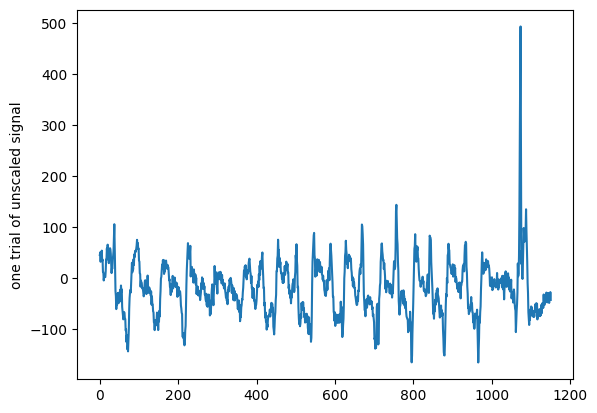

In [36]:
plt.plot(left[5][2]) # [trial][channel]
plt.ylabel('one trial of unscaled signal')
plt.show()

In [37]:
def shift(input_data):
    output = np.array(input_data)
    for i in range(len(input_data)):
        for j in range(4):
          output[i][j] = output[i][j] - sum(output[i][j]) / 1504
    return output.tolist()


def reshape(input_array):
    output_array = []
    for i in range(len(input_array)):
        each_trail = []
        before_trans = np.array(input_array[i])
        output_array.append(before_trans.transpose())
    return output_array

from sklearn.preprocessing import StandardScaler
def normalize(input_data):
    output_data = []
    for i in range(len(input_data)):
        scaler = StandardScaler()
        scaler.fit(input_data[i])
        scaled_X = scaler.transform(input_data[i])
        output_data.append(scaled_X)
    return output_data

In [38]:
import random
import math

# left, new_timesteps = filter(Ldata_collected, 32)
# right, new_timesteps = filter(Rdata_collected, 32)
# left = shift(left)
# right = shift(right)
# right = reshape(right)
# left = reshape(left)
left = shift(left)
right = shift(right)
right = reshape(right)
left = reshape(left)

label = []
X = []
# Add Labeles
for i in range(len(left)):
    label.append([0]) #set left to 1 and right to 0
    X.append(left[i])
for y in range(len(right)):
    label.append([1])
    X.append(right[y])

#shuffle arrays for randomness:
temp = list(zip(X, label))
random.shuffle(temp)
X, label = zip(*temp)
X = np.array(X)
label = np.array(label)

element_num = len(X)
train_index = element_num * 0.8 #choose 80% for training and 20% for validation
train_index = math.floor(train_index)
scaled_X = normalize(X) # normalize input data
scaled_X = np.array(scaled_X)
train_X = scaled_X[:train_index]
train_label = label[:train_index]
test_X = scaled_X[train_index:]
test_label = label[train_index:]

def convert_to_tensors(data):
    return tf.convert_to_tensor(data, dtype=tf.float32)

# Convert data to TensorFlow tensors
train_X_tensor = convert_to_tensors(train_X)
train_label_tensor = convert_to_tensors(train_label)
test_X_tensor = convert_to_tensors(test_X)
test_label_tensor = convert_to_tensors(test_label)

val_data = (test_X_tensor, test_label_tensor)

In [39]:
from tensorflow.keras.models import load_model

best_model = # best model name
# Load the model
model = load_model(os.path.join(path_to_model, best_model))

SyntaxError: invalid syntax (<ipython-input-39-a7e3eaa6512b>, line 3)

In [ ]:
history = model.fit(train_X_tensor, train_label_tensor, batch_size=8, epochs=50, validation_data=val_data)

In [ ]:
score = model.evaluate(test_X_tensor, test_label_tensor, verbose=0)
print(score)      #Score[0] is loss value and Score[1] is Accuracy